<a href="https://colab.research.google.com/github/ktongk/BTT-JPMC-1/blob/main/scrape_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Obtaining a list of equities tickers and the corresponding timeseries

In [31]:
! pip install --quiet yfinance ##--quiet mutes the package list as it’s installing

In [32]:
import os
import json
import numpy as np
import pandas as pd

import seaborn as sns
sns.set(rc={'figure.figsize':(10,8)})
import matplotlib.pyplot as plt


from datetime import datetime
''
# this workaround let's us override pandas_datareader with yfinance,
# although we can also use yfinance directly
import yfinance as yf
import pandas_datareader.data as web; yf.pdr_override()

In [33]:
# from google.colab import drive
# drive.mount('/content/drive')

In [34]:
start_date = '2022-01-01'
end_date  = '2022-12-31'

data_dir = 'data'

#A Timeline on the SVB Crash and why we Chose it

According to Investopedia, SVB Financial Group was removed from the S&P 500 Index due to the collapse its bank. So the most recent rebalancing of S&P 500 was announced on March 10, 2023.

The bank, mostly focused on venture capital funds and small tech startups had a huge boom during the pandemic. The bank then invested all of its profits into low-return bonds. However, after aggresive federal rate hikes the bonds quickly lost their value, causing panic. SVB no longer had the cash to give to the companies withdrawing their money and the FDIC took over the bank.







Initally the FDIC could only insure up to 250k but that wasn't enough, causing fear of a 2008 recession. The fed, treasury, and FDIC then announced a new emergency lending program so every company could get their money back.

##Timeseries Length
originally we were going to do the entire month of march but because there was a distinct end it didn't seem necesarry to do the full month. We decided to do a week before SVB announced their losses and then around a week after the emergency lending program was announced

##What other events did we consider?



We wanted to pick an event that had both positive and negative affects on the S&P500 companies and had a distinct beginning and end.

We considered doing the pandemic but it was too long and the rise of chatgpt but there were too many factors to consider (3.5 release, 4.0 release, 3.5 gets worse)
https://arxiv.org/pdf/2307.09009.pdf

In [35]:
names = ['','SVB announces 1.8 billion loss on bonds', 'SVB shares fall 60%, depositors withdraw money',
         'FDIC takes over SVB only insures up to 250k', 'Fed, Tresury, & FDIC say theyll cover all deposits',
         'Bank stocks bounced back in early trading','',
        ]

dates = ['2023-03-07','2023-03-08', '2023-03-09', '2023-03-10',
             '2023-03-12', '2023-03-14','2023-03-15'
        ]

    # Convert date strings (e.g. 2014-10-18) to datetime
dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates]

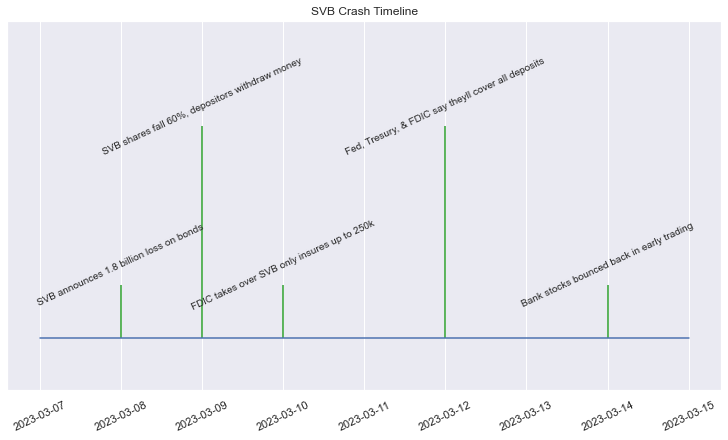

In [36]:
levels = np.tile([0, 1,4, 1, 4,1, 0], int(np.ceil(len(dates)/5)))[:len(dates)]

# Create figure and plot a stem plot with the date
fig, ax = plt.subplots(figsize=(10, 6), layout="constrained")
ax.set(title="SVB Crash Timeline")

ax.vlines(dates, 0, levels, color="tab:green")  # The vertical stems.
ax.plot(dates, np.zeros_like(dates))  # Baseline and markers on it.



for d, l, r in zip(dates, levels, names):
    ax.annotate(r, xy=(d, l), xytext=(0, 1* 20),# 0 means no horizontal offset and 1*20 means annotation will be 20 spaces from the end of the stem
                textcoords="offset points", horizontalalignment="center",
                verticalalignment="center", rotation=25, fontsize = 10)  # Rotate the text by 45 degrees

ax.set_ylim(-1, 6)
ax.yaxis.set_visible(False)
plt.xticks(rotation=25)
plt.show()

## Google trend search of the keyword "svb" 

In [37]:
# svb_google = pd.read_csv('svb_google_trend.csv')

# import matplotlib.dates as mdates

In [38]:

# svb_google['Day'] = pd.to_datetime(svb_google['Day'])

# # Filter the DataFrame to only include dates at a five-day interval
# df_filtered = svb_google[svb_google['Day'].dt.day % 1 == 0]

# x = df_filtered['Day']
# y = df_filtered['SVB: (District of Columbia)']


# # Create a DateFormatter object
# date_formatter = mdates.DateFormatter('%m-%d')

# # Set the DateFormatter as the major formatter for the x-axis
# plt.gca().xaxis.set_major_formatter(date_formatter)

# plt.plot(x, y)

# plt.xlabel('Date')
# plt.ylabel('Interest Over Time')

# plt.title('Interest over time of "SVB"')

# plt.show()


In [39]:
#  df.head()

## Get list of companies in S&P500

We will obtain and store the list of the constituents from Wikipedia.

In [40]:
data    = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies#S%26P_500_component_stocks')
table_symbol   = data[0]
table_industry = data[0]['GICS Sector']
symbols = list(table_symbol.Symbol.values) ##companies
industries = list(table_industry.values) ##Industry Sector

symbols_industries_dict = {}
symbols_industries = data[0].iloc[:, [0,2]].values.tolist()
for pair in symbols_industries:
  keys, values = pair
  symbols_industries_dict[keys] = values

print("{} symbols in total".format(len(symbols)))
print("{} industries in total".format(len(industries)))
print(industries)


503 symbols in total
503 industries in total
['Industrials', 'Industrials', 'Health Care', 'Health Care', 'Information Technology', 'Consumer Staples', 'Information Technology', 'Industrials', 'Utilities', 'Financials', 'Health Care', 'Consumer Discretionary', 'Materials', 'Information Technology', 'Industrials', 'Materials', 'Real Estate', 'Health Care', 'Industrials', 'Utilities', 'Financials', 'Communication Services', 'Communication Services', 'Consumer Staples', 'Consumer Discretionary', 'Materials', 'Information Technology', 'Utilities', 'Industrials', 'Utilities', 'Financials', 'Financials', 'Real Estate', 'Utilities', 'Financials', 'Industrials', 'Health Care', 'Information Technology', 'Information Technology', 'Information Technology', 'Financials', 'Energy', 'Information Technology', 'Information Technology', 'Consumer Discretionary', 'Financials', 'Information Technology', 'Financials', 'Financials', 'Communication Services', 'Utilities', 'Information Technology', 'Consumer

## Download price timeseries

Now that we have a list of ticker symbols, we can download the corresponding timeseries from Yahoo Finance.

In [41]:
symbols.append('SPY')

In [42]:
dates = '_{}--{}'.format(start_date, end_date)
dates

'_2022-01-01--2022-12-31'

In [43]:
'''
try:
  os.mkdir(data_dir)
except:
  print("Dir Error")
  '''

os.makedirs(data_dir, exist_ok=True)

In [44]:
#!ls /data


In [55]:
symbols = sorted(symbols)
print("Downloading {} files".format(len(symbols)))
for i, symbol in enumerate(symbols):
    try:
        df = web.get_data_yahoo(symbol, start_date, end_date,)
        # df = web.DataReader(symbol,'yahoo', start_date, end_date)
        df = df[['Adj Close','Volume']]
        df.to_csv(os.path.join(data_dir, "{}.csv".format(symbol)))
    except KeyError:
      print("Error for {}".format(symbol))
      pass
print("Stored {} files".format(i+1))



# symbols = sorted(symbols)
# print("Downloading {} files".format(len(symbols)))

# for i, symbol in enumerate(symbols):
#     # Check if the file for this symbol already exists in the data folder.
#     file_path = os.path.join(data_dir, "{}.csv".format(symbol))
#     if os.path.exists(file_path):
#         print("Skipping download for {}.".format(symbol))
#         continue

#     try:
#         # Download the file for this symbol.
#         df = web.get_data_yahoo(symbol, start_date, end_date,)
#         # df = web.DataReader(symbol,'yahoo', start_date, end_date)
#         df = df[['Adj Close','Volume']]
#         df.to_csv(file_path)
#     except KeyError:
#       print("Error for {}".format(symbol))
#       pass

# print("Stored {} files".format(i+1))


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******


1 Failed download:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2022-01-01 -> 2022-12-31)')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******


1 Failed download:
['KVUE']: Exception("%ticker%: Data doesn't exist for startDate = 1641013200, endDate = 1672462800")



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******


1 Failed download:
['VLTO']: Exception("%ticker%: Data doesn't exist for startDate = 1641013200, endDate = 1672462800")



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

In [56]:
# Printing a sample dataframe
idx = np.random.randint(len(symbols))
print("History for {}".format(symbols[idx]))
df = pd.read_csv(os.path.join(data_dir, symbols[idx]+".csv")).set_index('Date')
df.head()

History for HAL


,Adj Close,Volume
Date,,
2022-01-03,23.343794,9199200
2022-01-04,24.745008,17741700
2022-01-05,24.501740,11741400
2022-01-06,24.920160,8984600
2022-01-07,25.319117,8115100


## Pre-process Financial Timeseries

In [57]:
index = pd.date_range(start=start_date, end=end_date, freq='D')     # initialize an empty DateTime Index and so each index is a date over the month
df_price = pd.DataFrame(index=index, columns=symbols)               # initialize empty dataframes
df_volume = pd.DataFrame(index=index, columns=symbols)

In [58]:
# Aggregate all symbols into a price dataframe and volume dataframe
#for each ticker symbol get that csv file, set the index of that to the datetimes
#for each column in df_price is that company's adj price every datetime
for symbol in symbols:
    symbol_df = pd.read_csv(os.path.join(data_dir, symbol+".csv")).set_index('Date')
    symbol_df.index = pd.to_datetime(symbol_df.index)

    df_price[symbol] = symbol_df['Adj Close']
    df_volume[symbol] = symbol_df['Volume']

### Removing NaNs

In [59]:
# Let's drop the dates where all the stocks are NaNs, ie., weekends/holidays where no trading occured
df_price.dropna(how='all', inplace=True)
df_volume.dropna(how='all', inplace=True)
df_price.dropna(inplace=True, axis=1)
df_volume.dropna(inplace=True, axis=1)
assert((df_price.index == df_volume.index).all())

In [60]:
True in pd.isna(df_price)

False

### Storing the cleaned dataframes

In [61]:
#so instead of 500 csv files its now two
df_price.to_csv(os.path.join(data_dir, "prices.csv"), index_label='date')
df_volume.to_csv(os.path.join(data_dir, "volume.csv"))

#finds percent change between current price and prior
df_price_pct = df_price.pct_change()[1:]
df_price_pct.to_csv(os.path.join(data_dir, "prices_pct.csv"), index_label='date')
df_price_pct.head()

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
2022-01-04,-0.033806,0.014400,-0.012692,-0.001920,-0.010887,-0.023518,0.013019,-0.007146,-0.018374,-0.009032,...,-0.003190,0.006329,0.037614,0.005098,0.010608,0.005347,0.010145,0.006337,0.028487,-0.038072
2022-01-05,-0.017131,-0.017876,-0.026600,0.005253,-0.050059,-0.004493,-0.011744,-0.017611,-0.071426,-0.015437,...,-0.037033,0.009800,0.012438,-0.016090,-0.013629,-0.012677,-0.003297,-0.050068,0.002270,-0.038024
2022-01-06,0.003499,-0.005889,-0.016693,-0.004710,-0.015408,-0.000148,0.005830,-0.048290,-0.000603,0.003182,...,0.004629,-0.007821,0.023521,-0.000711,-0.001373,0.010331,-0.008307,-0.005410,0.041075,0.003971
2022-01-07,-0.026623,0.038234,0.000989,-0.002588,0.039437,0.003108,0.004681,-0.019180,-0.006652,-0.026241,...,-0.001063,0.008759,0.008197,0.003202,-0.007992,-0.011467,-0.006050,-0.043771,0.016681,-0.029114
2022-01-10,0.000069,-0.025415,0.000116,0.011195,-0.032159,-0.002213,0.021078,0.006069,0.029626,0.009239,...,-0.028149,0.010999,-0.005952,-0.016844,-0.010136,-0.013964,-0.009754,0.008571,-0.007562,0.007153


In [62]:
# expect to have (250, 498), which is 250 trading days and 498 stocks
df_price_pct.shape

(250, 498)

In [63]:
df_price.pct_change()[1:].to_csv(os.path.join(data_dir, 'prices_pct'+dates+'.csv'), index_label='date')
df_price.to_csv(os.path.join(data_dir, 'prices'+dates+'.csv'), index_label='date')

## Obtain Percentage Change and Correlation

We need to convert prices to percent change in price as opposed to the actual \$ price. This is because stocks with very similar prices can behave very differently and vice-versa.
For e.g., if a stock moves from \$100 to \$110, we want the price column to say 10% (indicating the change).

However, for volume, we will retain magnitude.

Spearman correlation

In [64]:
df_price_pct = df_price.pct_change().dropna(how='all')
df_volume_pct = df_volume.pct_change().dropna(how='all')

### Calculate Correlations

In [65]:
price_corr = df_price_pct.corr()
volume_corr = df_volume.corr()

In [66]:
price_corr.head()

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
A,1.000000,0.407709,0.655079,0.326509,0.508649,0.694500,0.387890,0.716137,0.646867,0.659650,...,0.412084,0.377577,0.244668,0.467659,0.644946,0.571664,0.549948,0.608282,0.486459,0.717034
AAL,0.407709,1.000000,0.578066,0.150788,0.656190,0.457502,0.443662,0.543218,0.471284,0.601553,...,0.547600,0.211978,0.117557,0.335173,0.518664,0.536259,0.494229,0.513814,0.554393,0.392053
AAPL,0.655079,0.578066,1.000000,0.237848,0.614346,0.626045,0.409057,0.793634,0.712878,0.757031,...,0.508320,0.435888,0.272653,0.446409,0.622754,0.577940,0.563028,0.714866,0.562130,0.669387
ABBV,0.326509,0.150788,0.237848,1.000000,0.064071,0.459729,0.231744,0.339734,0.183755,0.293730,...,0.077267,0.374313,0.180721,0.305446,0.274009,0.250046,0.322013,0.177527,0.264411,0.400356
ABNB,0.508649,0.656190,0.614346,0.064071,1.000000,0.453697,0.279895,0.609634,0.553967,0.624117,...,0.588347,0.114635,0.262851,0.432287,0.512740,0.547556,0.495450,0.566134,0.504051,0.490283


Text(0.5, 1.0, 'Correlation heatmap for Volume')

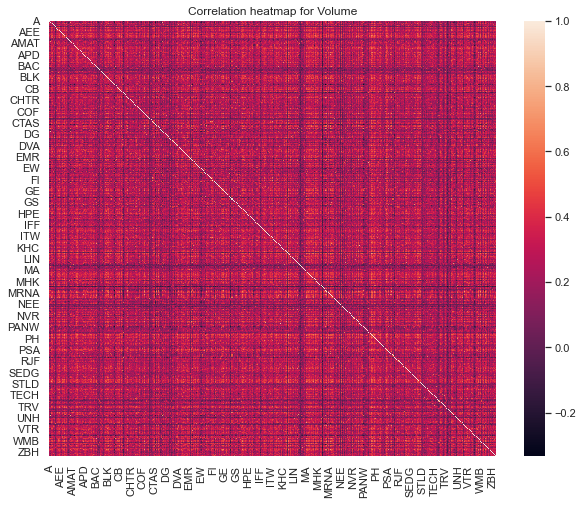

In [67]:
sns.heatmap(volume_corr).set_title("Correlation heatmap for Volume")

Text(0.5, 1.0, 'Correlation heatmap for Price Changes')

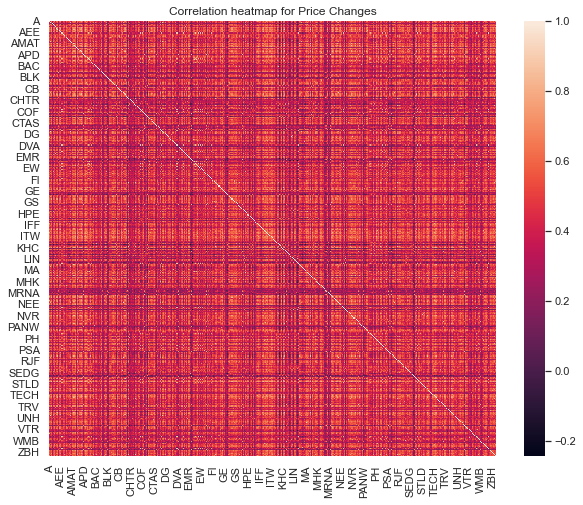

In [68]:
sns.heatmap(price_corr).set_title("Correlation heatmap for Price Changes")

### Examining correlations further

In [69]:
df_price_pct['JPM']

2022-01-04    0.037910
2022-01-05   -0.018282
2022-01-06    0.010624
2022-01-07    0.009908
2022-01-10    0.000957
                ...   
2022-12-23    0.004745
2022-12-27    0.003504
2022-12-28    0.005465
2022-12-29    0.005737
2022-12-30    0.006606
Name: JPM, Length: 250, dtype: float64

Text(0.5, 1.0, 'Price Change Scatterplot between JPM and GS. Correlation = 0.828099184067791')

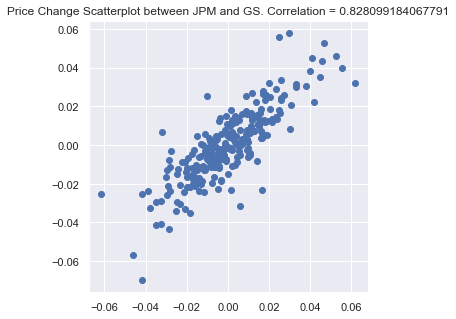

In [70]:
plt.figure(figsize=(5,5))
plt.scatter(df_price_pct['JPM'], df_price_pct['GS'])
plt.title('Price Change Scatterplot between JPM and GS. Correlation = {}'.format(price_corr['JPM']['GS']))

Summary statistics for the df_price_pct and df_volume dataframes and then boxplots to find outliers

In [ ]:
df_price_pct.head()

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
2022-01-04,-0.033806,0.014400,-0.012692,-0.001920,-0.010887,-0.023518,0.013019,-0.007146,-0.018374,-0.009032,...,-0.003190,0.006329,0.037614,0.005098,0.010608,0.005347,0.010145,0.006337,0.028487,-0.038072
2022-01-05,-0.017131,-0.017876,-0.026600,0.005253,-0.050059,-0.004493,-0.011744,-0.017611,-0.071426,-0.015437,...,-0.037033,0.009800,0.012437,-0.016089,-0.013629,-0.012677,-0.003297,-0.050068,0.002270,-0.038024
2022-01-06,0.003499,-0.005889,-0.016693,-0.004710,-0.015408,-0.000148,0.005830,-0.048291,-0.000603,0.003182,...,0.004629,-0.007822,0.023521,-0.000711,-0.001373,0.010331,-0.008307,-0.005410,0.041075,0.003971
2022-01-07,-0.026623,0.038234,0.000988,-0.002588,0.039437,0.003108,0.004681,-0.019180,-0.006652,-0.026241,...,-0.001063,0.008759,0.008197,0.003202,-0.007992,-0.011467,-0.006050,-0.043771,0.016681,-0.029114
2022-01-10,0.000069,-0.025415,0.000116,0.011195,-0.032159,-0.002213,0.021078,0.006069,0.029626,0.009239,...,-0.028149,0.010998,-0.005952,-0.016844,-0.010136,-0.013964,-0.009754,0.008571,-0.007562,0.007153


# Summary Stats and Outliers?
The below box plot is showing the price percentage change averaged across all 500 companies for each day, there's no outliers so it doesn't seem like theres one day in the timeseries where all the companies are all having drastic movement.




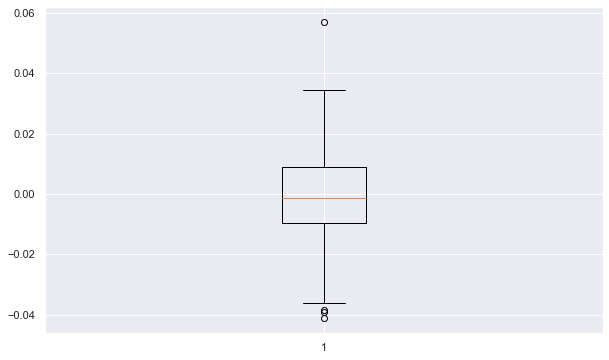

count    250.000000
mean      -0.000282
std        0.014769
min       -0.041220
25%       -0.009723
50%       -0.001187
75%        0.009027
max        0.056997
Name: average, dtype: float64

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
df_price_plotting = df_price_pct
df_price_plotting['average'] = df_price_plotting.mean(axis=1)
#average across all companies per day



# Creating plot
plt.boxplot(df_price_plotting['average'])

# show plot
plt.show()
df_price_plotting['average'].describe()

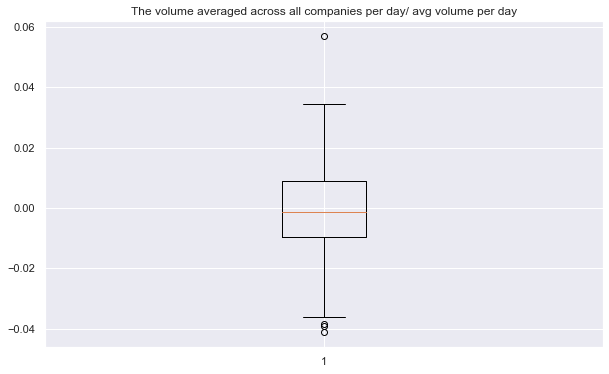

count    250.000000
mean      -0.000282
std        0.014769
min       -0.041220
25%       -0.009723
50%       -0.001187
75%        0.009027
max        0.056997
Name: average, dtype: float64

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(title="The volume averaged across all companies per day/ avg volume per day")
df_volume_summary_stats = df_volume.describe()
df_volume_summary_stats['average'] = df_volume_summary_stats.mean(axis=1)
df_volume_summary_stats['average']


# Creating plot
plt.boxplot(df_price_plotting['average'])

# show plot
plt.show()
df_price_plotting['average'].describe()

### Analyzng the distributions over time

This time instead of averaging every companies price change per day we're going to look at every company's price change over one day and make a separate boxplot to show the changes in distribution across the week of the crash

In [ ]:
# fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(20, 5), ncols=4)
# bxplt1 = ax1.boxplot(df_price_pct.loc['2023-03-03'])
# bxplt2 = ax2.boxplot(df_price_pct.loc['2023-03-09'])
# bxplt3 = ax3.boxplot(df_price_pct.loc['2023-03-16'])
# bxplt4 = ax4.boxplot(df_price_pct.loc['2023-03-20'])
# ax1.xaxis.set_visible(False)
# ax2.xaxis.set_visible(False)
# ax3.xaxis.set_visible(False)
# ax4.xaxis.set_visible(False)

# outliers1 = bxplt1["fliers"][0].get_ydata()
# outliers2 = bxplt2["fliers"][0].get_ydata()
# outliers3 = bxplt3['fliers'][0].get_ydata()
# outliers4 = bxplt4['fliers'][0].get_ydata()

# neg_outliers1 = outliers1[outliers1<0]
# neg_outliers2 = outliers2[outliers2<0]


# print('on march 2nd there was ', len(neg_outliers1), ' negative outliers and ', len(outliers1[outliers1>0]), 'positive outliers in the distribution')
# print('on march 9th there was ', len(neg_outliers2), ' negative outliers and ', len(outliers2[outliers2>0]), 'positive outliers in the distribution')
# print('on march 15th there was ', len(outliers3[outliers3<0]), ' negative outliers and ', len(outliers3[outliers3>0]), 'positive outliers in the distribution')
# print('on march 19th there was ', len(outliers4[outliers4<0]), ' negative outliers and ', len(outliers4[outliers4<0]), 'positive outliers in the distribution\n\n')

# ax1.set(title="Price % changes on march 3rd 2023 ")
# ax2.set(title="Price % changes on march 9th 2023")
# ax3.set(title= "Price % changes on march 16th 2023")
# ax4.set(title = "Price % changes on march 19th 2023")


In [72]:
df_price_pct.head()

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
2022-01-04,-0.033806,0.014400,-0.012692,-0.001920,-0.010887,-0.023518,0.013019,-0.007146,-0.018374,-0.009032,...,-0.003190,0.006329,0.037614,0.005098,0.010608,0.005347,0.010145,0.006337,0.028487,-0.038072
2022-01-05,-0.017131,-0.017876,-0.026600,0.005253,-0.050059,-0.004493,-0.011744,-0.017611,-0.071426,-0.015437,...,-0.037033,0.009800,0.012438,-0.016090,-0.013629,-0.012677,-0.003297,-0.050068,0.002270,-0.038024
2022-01-06,0.003499,-0.005889,-0.016693,-0.004710,-0.015408,-0.000148,0.005830,-0.048290,-0.000603,0.003182,...,0.004629,-0.007821,0.023521,-0.000711,-0.001373,0.010331,-0.008307,-0.005410,0.041075,0.003971
2022-01-07,-0.026623,0.038234,0.000989,-0.002588,0.039437,0.003108,0.004681,-0.019180,-0.006652,-0.026241,...,-0.001063,0.008759,0.008197,0.003202,-0.007992,-0.011467,-0.006050,-0.043771,0.016681,-0.029114
2022-01-10,0.000069,-0.025415,0.000116,0.011195,-0.032159,-0.002213,0.021078,0.006069,0.029626,0.009239,...,-0.028149,0.010999,-0.005952,-0.016844,-0.010136,-0.013964,-0.009754,0.008571,-0.007562,0.007153


In [86]:

df_subset_1 = df_price_pct.loc['2022-03-03':'2022-03-20']
df_subset_1.shape

(12, 498)

This is also shown in the line graph showing how during the week of the crash, healthcare company ABT stayed consistent with the monthly trends while financial company charles schwab had one of its lowest price drops. Tesla, a silicon tech company had big drop on the 9th but rebounded pretty quickly

I wanted to show how the crash affects other sectors besides financial

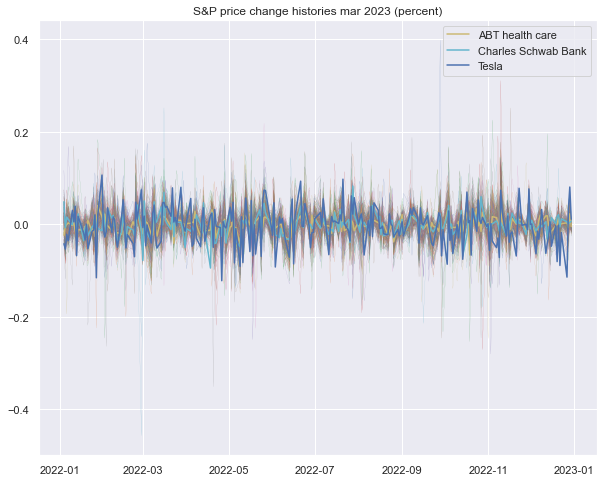

In [87]:
plt.title('S&P price change histories mar 2023 (percent)')
plt.plot(df_price_pct, linewidth=0.10)
plt.plot(df_price_pct['ABT'], label='ABT health care', linewidth=1.5)
plt.plot(df_price_pct['SCHW'], label = 'Charles Schwab Bank', linewidth=1.5)
plt.plot(df_price_pct['TSLA'], label = 'Tesla', linewidth=1.5)
plt.legend()

## <font color= "9900CC">**Not every company reacted the same way**
In the original time series used for the file, JPMC and GS's price changes were consistent with each other throughout the month. However, when we set the timeseries to march 2023, during the week of the SVB crash they diverge drastically, this is because while GS suffered due to uncertaintiy w/ the economy, JPMC was in talks to accquire SVB thus their price sky rocketed so you can't definetively say every financial company suffered due to the crash.

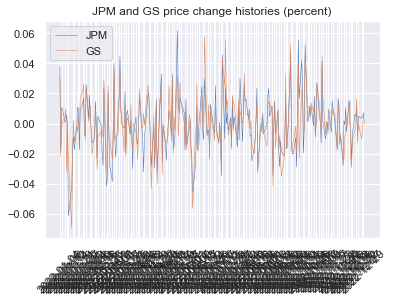

In [ ]:
plt.title('JPM and GS price change histories (percent)')
plt.plot(df_price_pct['JPM'], label='JPM', linewidth=0.5)
plt.plot(df_price_pct['GS'], label='GS', linewidth=0.5)
dates = list(df_price_pct.index.values)
plt.xticks([dates[i] for i in range(len(dates)) if i % 2 == 0], rotation=45)
plt.legend()

In [ ]:
df_price_pct_summary_stats = df_price_pct.describe()
df_price_pct_summary_stats['average'] = df_price_pct_summary_stats.mean(axis=1)
print('summary statistics for price (not pct change) averaged across all companies')
#df_price_pct_summary_stats.head()
print(df_price_pct_summary_stats['average'])

summary statistics for price (not pct change) averaged across all companies
count    250.000000
mean      -0.000282
std        0.022574
min       -0.088301
25%       -0.013699
50%       -0.000431
75%        0.013217
max        0.084915
Name: average, dtype: float64


## Saving correlation dataframes

In [ ]:
#df_price_pct.to_csv(os.path.join(data_dir, 'price_pct.csv'), index_label='date')
price_corr.to_csv(os.path.join(data_dir, 'price_corr.csv'), index_label='Symbol')
volume_corr.to_csv(os.path.join(data_dir, 'volume_corr.csv'))

## CREATE A HEATMAP WITH THRESHOLD OF ONLY ABOVE 0.7(Does it help?)

Text(0.5, 1.0, 'Price Correlation Heatmap')

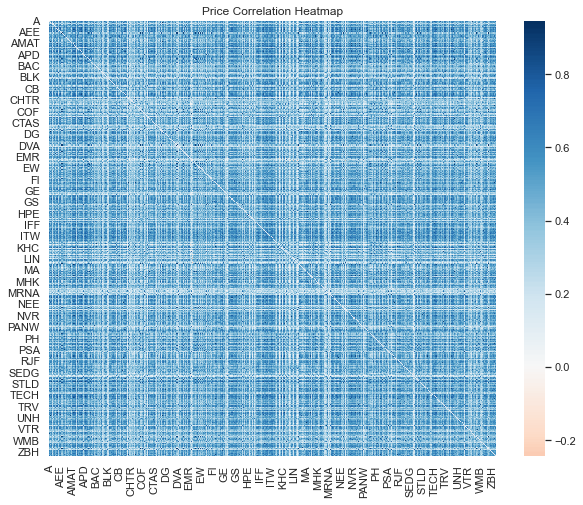

In [94]:

# threshold = 0.7
threshold = 0.95

# Create a mask to hide the upper triangle of the heatmap
mask = price_corr.abs() > threshold

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(price_corr, cmap='RdBu', mask=mask, center=0)
plt.title('Price Correlation Heatmap')


# Correlation Analysis - clustering
Group companies together using clustering techniques
Then, apply statistical methods, such as correlation analysis, to identify relationships and patterns within the company graph


Hiericharical clustering:
- Distance computing 

Dendrogram: 
- Single linkage
        - A distance between clusters in the tree is calculated using the shortest distance between them.
- Average linkage (UPGMA) - A distance between clusters in the tree is calculated using average distance between them.
- Complete linkage - A distance between clusters in the tree is calculated using the longest distance between them.
- Ward - At every step of clustering two clusters that result into a minimal loss of information are combined. Information loss is measured using error sum-of-squares criterion.




Steps for clustering based on price change:
step 0: decide the number of clusters required, which is the threshold of abs value of 95%
step 1: create a scatter plot
step 2: normalize the data
step 3: calculate eclidean distance
step 4: create a dendogram



In [95]:
df_price_pct.head()

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
2022-01-04,-0.033806,0.014400,-0.012692,-0.001920,-0.010887,-0.023518,0.013019,-0.007146,-0.018374,-0.009032,...,-0.003190,0.006329,0.037614,0.005098,0.010608,0.005347,0.010145,0.006337,0.028487,-0.038072
2022-01-05,-0.017131,-0.017876,-0.026600,0.005253,-0.050059,-0.004493,-0.011744,-0.017611,-0.071426,-0.015437,...,-0.037033,0.009800,0.012438,-0.016090,-0.013629,-0.012677,-0.003297,-0.050068,0.002270,-0.038024
2022-01-06,0.003499,-0.005889,-0.016693,-0.004710,-0.015408,-0.000148,0.005830,-0.048290,-0.000603,0.003182,...,0.004629,-0.007821,0.023521,-0.000711,-0.001373,0.010331,-0.008307,-0.005410,0.041075,0.003971
2022-01-07,-0.026623,0.038234,0.000989,-0.002588,0.039437,0.003108,0.004681,-0.019180,-0.006652,-0.026241,...,-0.001063,0.008759,0.008197,0.003202,-0.007992,-0.011467,-0.006050,-0.043771,0.016681,-0.029114
2022-01-10,0.000069,-0.025415,0.000116,0.011195,-0.032159,-0.002213,0.021078,0.006069,0.029626,0.009239,...,-0.028149,0.010999,-0.005952,-0.016844,-0.010136,-0.013964,-0.009754,0.008571,-0.007562,0.007153


In [96]:
df_price_pct[:0].T
#set df_price_pct[:0].T as the labels

labels = df_price_pct.iloc[:1].T

In [97]:
dissimilarity = 1 - abs(df_price_pct.corr().values) 

In [98]:
# print(dissimilarity.shape) #The shape is: (501, 501), so we are good to go
# Since we have the correlation of itself to be 0, the next is to 
dissimilarity


array([[0.        , 0.59229094, 0.34492066, ..., 0.39171763, 0.51354133,
        0.28296627],
       [0.59229094, 0.        , 0.42193377, ..., 0.48618628, 0.44560694,
        0.60794657],
       [0.34492066, 0.42193377, 0.        , ..., 0.28513401, 0.43787047,
        0.33061314],
       ...,
       [0.39171763, 0.48618628, 0.28513401, ..., 0.        , 0.45964069,
        0.40875436],
       [0.51354133, 0.44560694, 0.43787047, ..., 0.45964069, 0.        ,
        0.52732202],
       [0.28296627, 0.60794657, 0.33061314, ..., 0.40875436, 0.52732202,
        0.        ]])

In [99]:
dissimilarity.shape

(498, 498)

In [100]:
# Cluster: build the linkage matrix
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist, squareform



In [101]:

from scipy.cluster.hierarchy import *
complete_linkage = linkage(squareform(dissimilarity), method = 'complete')

Complete linkage: This method considers the distance between two clusters to be equal to the greatest distance from any member of one cluster to any member of the other cluster. If the data contains outliers, complete linkage may be more robust against them than single linkage.

Ward's method: This method minimizes the total within-cluster variance. At each step, the pair of clusters with the minimum between-cluster distance are merged. It's generally regarded as very efficient and is often used in practice.

Why do we use complete linkage here? 

It takes the maximum distance between the two clusters. 

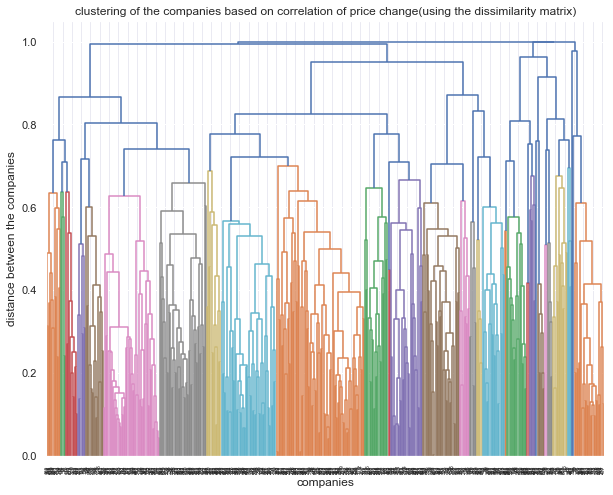

In [102]:
dendrogram = dendrogram(complete_linkage)

plt.xlabel("companies")
plt.ylabel("distance between the companies")

plt.title("clustering of the companies based on correlation of price change(using the dissimilarity matrix)")
plt.show()

In [103]:
from scipy.cluster.hierarchy import *
ward_linkage = linkage(squareform(dissimilarity), method = 'ward')

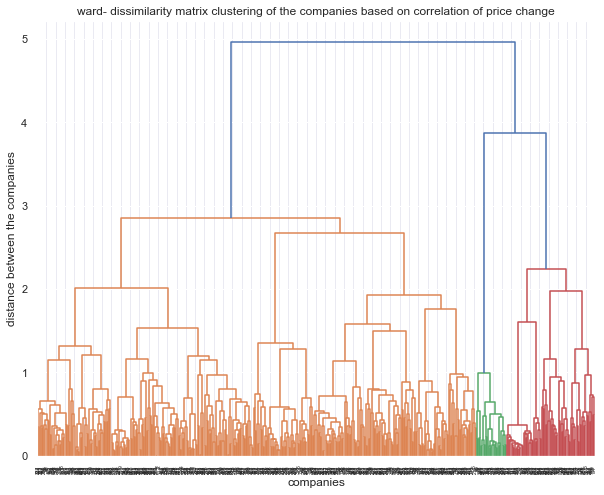

In [107]:
dendrogram_ward = dendrogram(ward_linkage)

plt.xlabel("companies")
plt.ylabel("distance between the companies")

plt.title("ward- dissimilarity matrix clustering of the companies based on correlation of price change")
plt.show()

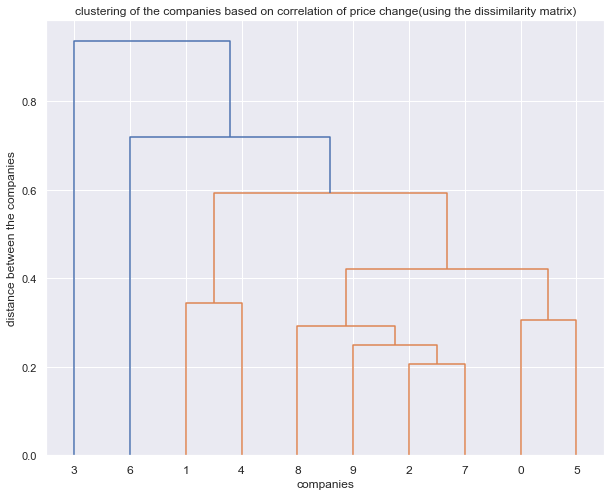

In [106]:
dissimilarity_10 = dissimilarity[:10,:10]
complete_linkage_10 = linkage(squareform(dissimilarity_10), method = 'complete')
dendrogram_ward = dendrogram(complete_linkage_10)

plt.xlabel("companies")
plt.ylabel("distance between the companies")

plt.title("clustering of the companies based on correlation of price change(using the dissimilarity matrix)")
plt.show()

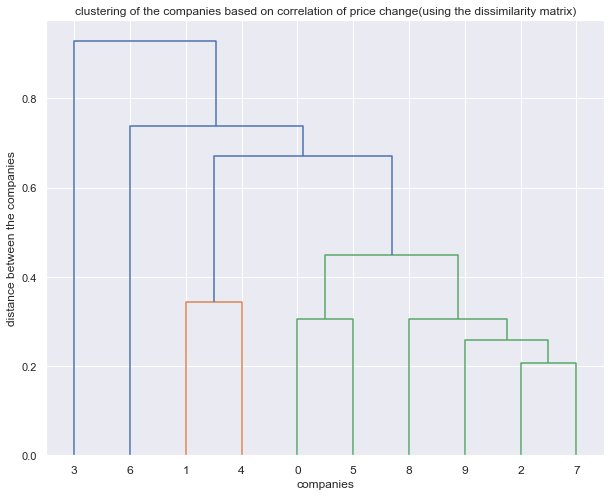

In [109]:
#show the first ten companies of the dissimilarity matrix to see if it makes sense
dissimilarity_10 = dissimilarity[:10,:10]
ward_linkage_10 = linkage(squareform(dissimilarity_10), method = 'ward')
dendrogram_ward = dendrogram(ward_linkage_10)

plt.xlabel("companies")
plt.ylabel("distance between the companies")

plt.title("clustering of the companies based on correlation of price change(using the dissimilarity matrix)")
plt.show()


Text(0, 0.5, 'distance between the companies')

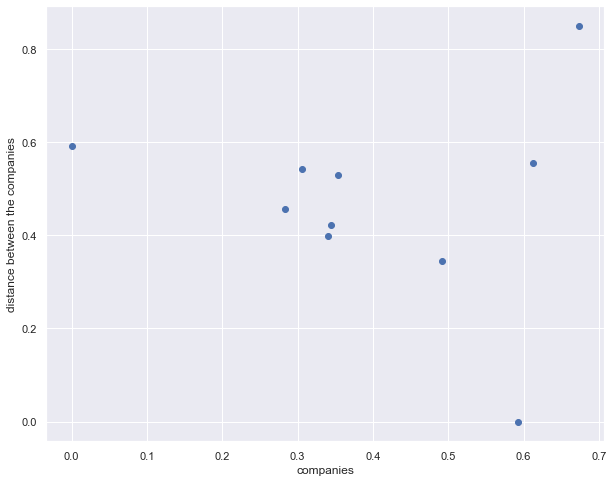

In [110]:
#create a scatter plot of the first dissimilarity_10
plt.scatter(dissimilarity_10[:,0], dissimilarity_10[:,1])

plt.xlabel("companies")
plt.ylabel("distance between the companies")

To help assess which clustering linkage to select, we use cophenetic distance.

The cophenetic distance between two objects is the height of the dendrogram where the two branches that include the two objects merge into a single branch. Outside the context of a dendrogram, it is the distance between the largest two clusters that contain the two objects individually when they are merged into a single cluster that contains both.


In [123]:
dissimilarity = squareform(dissimilarity)
dissimilarity[:10]

array([0.59229094, 0.34492066, 0.67349064, 0.49135057, 0.30549958,
       0.61211036, 0.28386286, 0.35313342, 0.34034969, 0.6998339 ])

In [122]:
dissimilarity[:10][:10]

array([[0.        , 0.59229094, 0.34492066, ..., 0.39171763, 0.51354133,
        0.28296627],
       [0.59229094, 0.        , 0.42193377, ..., 0.48618628, 0.44560694,
        0.60794657],
       [0.34492066, 0.42193377, 0.        , ..., 0.28513401, 0.43787047,
        0.33061314],
       ...,
       [0.28386286, 0.45678199, 0.20636599, ..., 0.28789179, 0.40590193,
        0.27580204],
       [0.35313342, 0.52871598, 0.28712197, ..., 0.35312805, 0.58181492,
        0.36143498],
       [0.34034969, 0.3984469 , 0.24296917, ..., 0.31394965, 0.44321058,
        0.38465204]])

In [125]:
dissimilarity.shape

(498, 498)

Cophenetic Correlation for Average Linkage: [2.65413376 2.29520407 5.97477075 ... 2.65413376 2.348167   2.65413376]
Cophenetic Correlation for Complete Linkage: [ 4.99069615  6.29491745 11.33899961 ...  6.29491745  6.29491745
  4.48200538]
Cophenetic Correlation for Ward Linkage: [26.54583125 26.54583125 58.45780699 ... 16.34961894 26.54583125
 26.54583125]
Cophenetic Correlation for Single Linkage: [1.21965664 1.04130874 1.70004877 ... 1.07327081 1.06939768 1.07327081]


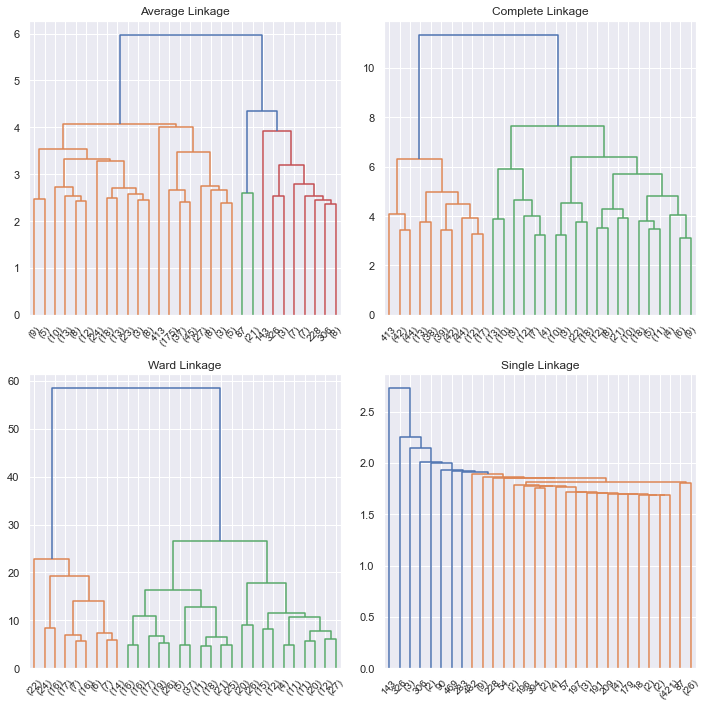

In [140]:
from scipy.cluster.hierarchy import linkage, cophenet, dendrogram
from scipy.spatial.distance import pdist
import numpy as np
import matplotlib.pyplot as plt

dist_matrix = pdist(dissimilarity)

# Hierarchical clustering
linkage_matrix_average = linkage(dist_matrix, method='average')
linkage_matrix_complete = linkage(dist_matrix, method='complete')
linkage_matrix_ward = linkage(dist_matrix, method='ward')
linkage_matrix_single = linkage(dist_matrix, method='single')

# Cophenetic Distances and Correlations
coph_dist_average, coph_corr_average = cophenet(linkage_matrix_average, dist_matrix)
coph_dist_complete, coph_corr_complete = cophenet(linkage_matrix_complete, dist_matrix)
coph_dist_ward, coph_corr_ward = cophenet(linkage_matrix_ward, dist_matrix)
coph_dist_single, coph_corr_single = cophenet(linkage_matrix_single, dist_matrix)


# Print Cophenetic Correlations directly
print(f'Cophenetic Correlation for Average Linkage: {coph_corr_average}')
print(f'Cophenetic Correlation for Complete Linkage: {coph_corr_complete}')
print(f'Cophenetic Correlation for Ward Linkage: {coph_corr_ward}')
print(f'Cophenetic Correlation for Single Linkage: {coph_corr_single}')

# Dendrograms
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

dendrogram(linkage_matrix_average, ax=axes[0, 0], truncate_mode='lastp')
axes[0, 0].set_title('Average Linkage')

dendrogram(linkage_matrix_complete, ax=axes[0, 1], truncate_mode='lastp')
axes[0, 1].set_title('Complete Linkage')

dendrogram(linkage_matrix_ward, ax=axes[1, 0], truncate_mode='lastp')
axes[1, 0].set_title('Ward Linkage')

dendrogram(linkage_matrix_single, ax=axes[1, 1], truncate_mode='lastp')
axes[1, 1].set_title('Single Linkage')

plt.tight_layout()
plt.show()

In [142]:
from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn.metrics import calinski_harabasz_score

In [143]:
thresholds = [.05,.1,.15,.2,.25,.3,.35,.4,.45,.5,.55,.6,.65]
#silhouette_scores = []
linkage_methods = ['complete','ward','median','average','centroid','weighted']
#cophenet_correlations = []

#im going to store the results of this for loop into a dataframe so i can compare everything better
columns = ['threshold','Silhouette','linkage', 'cophenet corr', 'ch index']
price_corr_eval = pd.DataFrame(columns=columns)

for t in thresholds:
        
        for l in linkage_methods:
                Z = linkage(squareform(dissimilarity), l)
                labels = fcluster(Z, t, criterion='distance')
                silhouette_avg = silhouette_score(dissimilarity, labels, metric='precomputed')
                #silhouette_scores.append(silhouette_avg)

                c, _ = cophenet(Z, squareform(dissimilarity))
                #cophenet_correlations.append(c)
                ch = calinski_harabasz_score(dissimilarity, labels)
                new_row = [t, silhouette_avg, l, c,ch]
                price_corr_eval.loc[len(price_corr_eval)] = new_row
                #print(f"Silhouette Score for threshold {t}: {silhouette_avg} and cophenet corr for link method {l}: {c}")

price_corr_eval.loc[:10]


,threshold,Silhouette,linkage,cophenet corr,ch index
0,0.05,0.014340,complete,0.496662,124.769601
1,0.05,0.014340,ward,0.619513,124.769601
2,0.05,0.014340,median,0.681205,124.769601
3,0.05,0.014340,average,0.771211,124.769601
4,0.05,0.014340,centroid,0.755633,124.769601
5,0.05,0.014340,weighted,0.705247,124.769601
6,0.10,0.054523,complete,0.496662,45.466732
7,0.10,0.051026,ward,0.619513,47.289261
8,0.10,0.054303,median,0.681205,42.820198
9,0.10,0.054523,average,0.771211,45.466732


In [144]:
def custom_score(row):
    return row['Silhouette'] + row['cophenet corr']

# Apply the custom score function to each row in the DataFrame
price_corr_eval['Custom_Score'] = price_corr_eval.apply(custom_score, axis=1)

# Find the entry with the highest custom score
max_entry = price_corr_eval[price_corr_eval['Custom_Score'] == price_corr_eval['Custom_Score'].max()]

# Print the entry with the highest custom score
max_entry

,threshold,Silhouette,linkage,cophenet corr,ch index,Custom_Score
76,0.65,0.242777,centroid,0.755633,3.773416,0.998409


In [146]:
max_index = price_corr_eval['Custom_Score'].idxmax()
max_entry = price_corr_eval.loc[max_index]
print(max_entry)

threshold            0.65
Silhouette       0.242777
linkage          centroid
cophenet corr    0.755633
ch index         3.773416
Custom_Score     0.998409
Name: 76, dtype: object


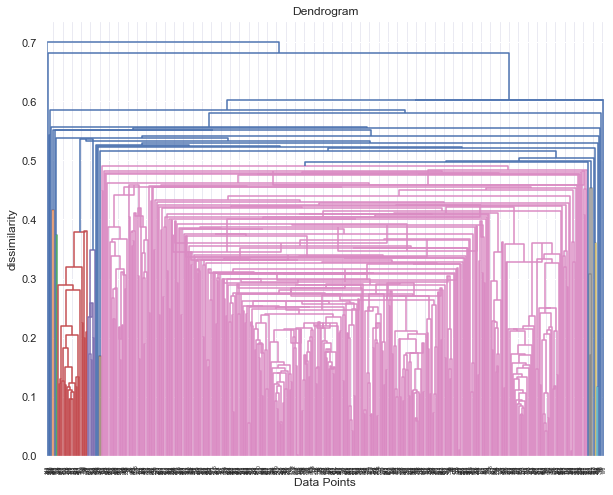

there are three clustres and these are the sizes of each [496, 1, 1]


In [145]:
Z = linkage(squareform(dissimilarity), method="centroid", optimal_ordering=True)

dendrogram = sch.dendrogram(Z)
plt.xlabel('Data Points')
plt.ylabel('dissimilarity')
plt.title('Dendrogram')
plt.show()

labels = fcluster(Z, .65, criterion='distance')
silhouette_avg = silhouette_score(dissimilarity, labels, metric='precomputed')
num_clusters = len(set(labels))


unique_labels = np.unique(labels)
cluster_sizes = [np.sum(labels == label) for label in unique_labels]

# Calculate the ratio of cluster sizes
size_ratio = max(cluster_sizes) / min(cluster_sizes)
print('there are three clustres and these are the sizes of each', cluster_sizes)

In [138]:
coph_corr_average.shape #(123753,)

(123753,)

## Find the number of clusters and visualize it 

In [ ]:
! pip install gap-stat

In [91]:
# figure out the optimal number of clusters
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
# from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score


 

In [92]:
def calculate_silhouette_score(linkage_matrix, dissimilarity_matrix, n_clusters):
    clusters = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')
    silhouette_avg = silhouette_score(dissimilarity_matrix, clusters)
    return silhouette_avg

In [88]:
dissimilarity_corr = 1 - df_price_pct.corr().values

In [ ]:

labels = fcluster(Z, .55, criterion='distance')
silhouette_avg = silhouette_score(dissimilarity, labels, metric='precomputed')
num_clusters = len(set(labels))


unique_labels = np.unique(labels)
cluster_sizes = [np.sum(labels == label) for label in unique_labels]

# Calculate the ratio of cluster sizes
size_ratio = max(cluster_sizes) / min(cluster_sizes)
print('there are three clustres and these are the sizes of each', cluster_sizes)

there are three clustres and these are the sizes of each [2, 2, 487, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
#create a dendrogram with 4 clusters for the dissimilarity matrix
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt


In [ ]:
# Silhouette score low - less similarity

from sklearn.metrics import silhouette_score


thresholds = [.5,.4,.3,.2,.1]
for t in thresholds:
        labels = fcluster(complete_linkage_10, t, criterion='distance')
        silhouette_avg = silhouette_score(dissimilarity_10, labels, metric='precomputed')
        print(f"Silhouette Score for threshold {t}: {silhouette_avg} ")
#cophenetic score
c, _ = cophenet(complete_linkage_10, squareform(dissimilarity_10))
print("cophenetic corr ",c)

labels_final = fcluster(complete_linkage_10,.2,criterion='distance')
clusters_dict = dict(zip(df_price_pct.columns, labels_final))

Silhouette Score for threshold 0.5: 0.2692680589309156 
Silhouette Score for threshold 0.4: 0.19583566692781734 
Silhouette Score for threshold 0.3: 0.28910734054583875 
Silhouette Score for threshold 0.2: 0.23340466859589898 
Silhouette Score for threshold 0.1: 0.06495055572294331 
cophenetic corr  0.6698272307304043


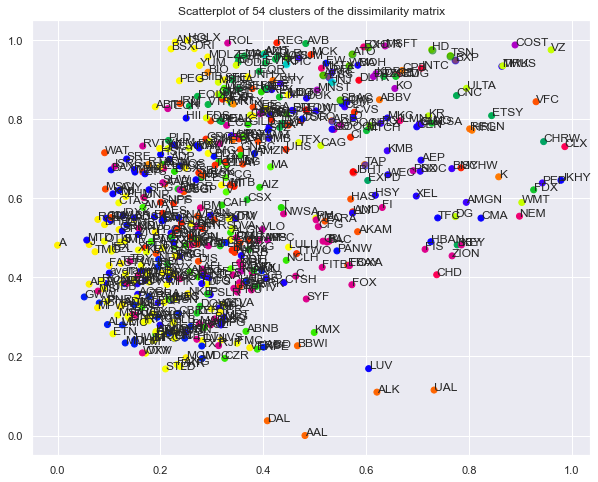

In [ ]:
#create a scatterplot of 54 clusters of the dissimilarity matrix
plt.figure(figsize=(10, 8))
plt.scatter(dissimilarity[:,0], dissimilarity[:,1], c=clusters, cmap='prism')  # plot points with cluster dependent colors
plt.title('Scatterplot of 54 clusters of the dissimilarity matrix')
#label the points
for i, txt in enumerate(df_price_pct.columns):
    plt.annotate(txt, (dissimilarity[i,0], dissimilarity[i,1]))
    
# cirlce the ones that are in one cluster
plt.scatter(dissimilarity[clusters==1,0], dissimilarity[clusters==1,1], c='red', s=50, alpha=0.5);
plt.scatter(dissimilarity[clusters==2,0], dissimilarity[clusters==2,1], c='blue', s=50, alpha=0.5);
plt.scatter(dissimilarity[clusters==3,0], dissimilarity[clusters==3,1], c='green', s=50, alpha=0.5);
plt.scatter(dissimilarity[clusters==4,0], dissimilarity[clusters==4,1], c='cyan', s=50, alpha=0.5);
plt.show()




In [ ]:
# What to do next with the clusters?
# 1. Find the most representative company for each cluster
# 3. Predict the next day's price change for each company based on the cluster it belongs to

# How to find the most representative company for each cluster?
# 1. Find the most similar company to the centroid of each cluster
# 2. Find the company with the highest average correlation to other companies in the same cluster


## Grouping the companies based on the daily return?


Now we have the dendrogram and the clusters of the 500 companies into 54 clusters, it's time to create a prediction based on the number of clusters we have. 
How to approach it? test on the 10 sample companies first. 

# Building the Model- using XGboost to predict 